This file contains the class for SHAP (SHapley Additive exPlanations) model interpretability.

Reference:
Lundberg, S. M., & Lee, S.-I. (2017). A Unified Approach to Interpreting Model Predictions. 
URL: http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf

author: Julius
date: Jun 2025

In [3]:
import pandas as pd
import torch
import shap
from xgboost import XGBRegressor

In [4]:
class shap_fairness_explainer:
    """
    Wraps SHAP explainability for fairness auditing.

    Parameters:
        dataset: Dataset object with .data, .i2c, .c2i
        parameters: dict with:
            - "model": trained model (e.g. XGBRegressor)
            - "features_model": list of feature names used in the model
    """

    def __init__(self, dataset, parameters):
        self.dataset = dataset
        self.model = parameters["model"]
        self.feature_names = parameters["features_model"]

        # Map feature names to column indices
        self.feature_indices = [dataset.c2i[f] for f in self.feature_names]

        # Extract feature matrix as numpy array for SHAP
        self.X = dataset.data[:, self.feature_indices].numpy()

        # Create SHAP explainer and compute SHAP values
        self.explainer = shap.Explainer(self.model, self.X)
        self.shap_values = self.explainer(self.X)

    def feature_importance(self, max_display=10):
        """
        Show violin plot of SHAP values (feature importance per instance).
        """
        shap.plots.violin(self.shap_values, max_display=max_display)

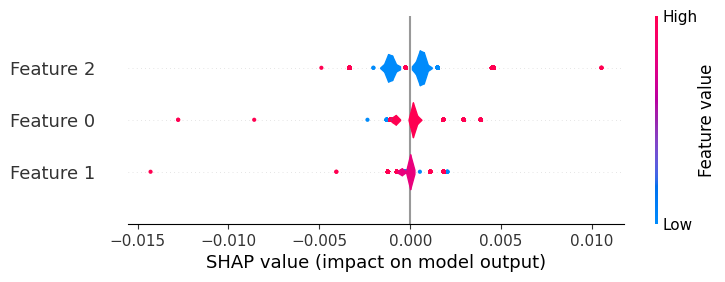

In [ ]:
PATH = "data/synth_data_preds.csv"


def load_csv_to_torch(path=PATH):
    df = pd.read_csv(path)
    i2c = df.columns.tolist()
    c2i = {c: i for i, c in enumerate(i2c)}
    data_torch = torch.from_numpy(df.values)
    return data_torch, (i2c, c2i)


class Dataset:
    def __init__(self, PATH):
        data, (i2c, c2i) = load_csv_to_torch(PATH)
        self.data = data
        self.i2c = i2c
        self.c2i = c2i


data = Dataset(PATH)

features = [
    "competentie_omgaan_met_verandering_en_aanpassen",
    "competentie_onderzoeken",
    "adres_aantal_woonadres_handmatig",
]

X_indices = [data.c2i[f] for f in features]
y_index = data.c2i["predictions"]

X = data.data[:, X_indices].numpy()
y = data.data[:, y_index].numpy()

model = XGBRegressor()
model.fit(X, y)

param = {"model": model, "features_model": features}
explainer = shap_fairness_explainer(data, param)
explainer.feature_importance()